import

In [1]:
%matplotlib inline
import os
import torch

import matplotlib.pyplot as plt
import torchvision.models as models

from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

import dataLoader
from configParser import ConfigParser, getModelName

cuda

In [2]:
# CUDA support 
if torch.cuda.is_available():
    torch.cuda.set_device(0) # 0
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("We are using cuda")

We are using cuda


parameters

In [3]:
# params
experimentName = "test_22987_suffix50_11_CNN2_differentConfig_softmax_multi"
experiment_index = 0
trial_index=0
experiment_type = "multi-trial"

importLoad experiment

In [4]:
from configParser import ConfigParser
config_parser = ConfigParser(experimentName)

experimentName = os.path.join(experimentName, experiment_type)
print(experimentName)

test_22987_suffix50_11_CNN2_differentConfig_softmax_multi/multi-trial


load dataset

In [5]:
if experiment_type == "multi-trial":
    paramsIterator = config_parser.getHyperpIter()
# TODO: add more cases
for indx, e in enumerate(paramsIterator):
    if indx ==experiment_index:
        experiment_params = e
        break
print(experiment_params)

datasetManager = dataLoader.datasetManager(experimentName, True)
datasetManager.updateParams(experiment_params)
dataset = datasetManager.getDataset()
dataset.toggle_image_loading(augmentation=False, normalization=False)

{'image_path': '/data/BGNN_data/INHS_cropped', 'suffix': '50_11', 'training_count': 0.64, 'validation_count': 0.16, 'imageDimension': 224, 'n_channels': 3, 'augmentation': False, 'batchSize': 550, 'n_epochs': 1000, 'learning_rate': 0.0001, 'numOfTrials': 3, 'patience': 100, 'useHeirarchy': True, 'useRelu': True, 'downsample': True, 'downsampleOutput': 50, 'takeFromIntermediate': True, 'takeFromIntermediateOutput': 50, 'fc_layers': 1, 'useAdam': True, 'resnet': '18', 'normalize': False, 'softmax': False}
file /data/BGNN_data/INHS_cropped/50_11/test_22987_suffix50_11_CNN2_differentConfig_softmax_multi/multi-trial/tc0.640000_vc0.160000_d224_c3_augFalse_nFalse/dataset.pkl read


(False, False)

Load model of a specific trial

In [6]:
#TODO: could be useful to move this to its own function

import CNN

speciesList = dataset.getSpeciesList()
numberOfSpecies = len(speciesList)
genusList = dataset.getGenusList()
numberOfGenus = len(genusList)
trialName = os.path.join(experimentName, getModelName(experiment_params, trial_index))

architecture = {
    "species": numberOfSpecies,
    "genus" : numberOfGenus
}
model = CNN.create_model(architecture, experiment_params)
loss_list, accuracy_list, epochs, time_elapsed = CNN.loadModel(model, trialName)

Params: Which output to optimize for.

In [7]:
# params
outputs = {
    "species": True,
    "genus" : False
}

Model wrapper

In [8]:
#TODO: move this to CNN file
from torchsummary import summary
    
class CNN_wrapper(torch.nn.Module):
    
    # Contructor
    def __init__(self, model):
                
        super(CNN_wrapper, self).__init__()
        self.model = model

#         summary(model, (3, 224, 224))
        
#         for _, module in self.model.named_modules():
#             print(module)

    
    # Prediction
    def forward(self, x):
        result = self.model.activations(x, outputs=outputs)
        if outputs['species']:
            result = result['species']
        elif outputs['genus']:
            result = result['genus']
        return result

In [9]:
Backprop

flashtorch.saliency.backprop.Backprop

In [10]:
wrapped_model = CNN_wrapper(model)
backprop = Backprop(wrapped_model)

Modify flashtorch visualization function

In [11]:
# TODO: move this to a flashtorch wrapper
from flashtorch.utils import (denormalize,
                              format_for_plotting,
                              standardize_and_clip)

def visualize(self, input_, target_class, guided=False, use_gpu=False,
                  figsize=(16, 4), cmap='viridis', alpha=.5,
                  return_output=False):
        """Calculates gradients and visualizes the output.
        A method that combines the backprop operation and visualization.
        It also returns the gradients, if specified with `return_output=True`.
        Args:
            input_ (torch.Tensor): With shape :math:`(N, C, H, W)`.
            target_class (int, optional, default=None)
            take_max (bool, optional, default=False): If True, take the maximum
                gradients across colour channels for each pixel.
            guided (bool, optional, default=Fakse): If True, perform guided
                backpropagation. See `Striving for Simplicity: The All
                Convolutional Net <https://arxiv.org/pdf/1412.6806.pdf>`_.
            use_gpu (bool, optional, default=False): Use GPU if set to True and
                `torch.cuda.is_available()`.
            figsize (tuple, optional, default=(16, 4)): The size of the plot.
            cmap (str, optional, default='viridis): The color map of the
                gradients plots. See avaialable color maps `here <https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html>`_.
            alpha (float, optional, default=.5): The alpha value of the max
                gradients to be jaxaposed on top of the input image.
            return_output (bool, optional, default=False): Returns the
                output(s) of optimization if set to True.
        Returns:
            gradients (torch.Tensor): With shape :math:`(C, H, W)`.
        """

        # Calculate gradients

        gradients = self.calculate_gradients(input_,
                                             target_class,
                                             guided=guided,
                                             use_gpu=use_gpu)
        max_gradients = self.calculate_gradients(input_,
                                                 target_class,
                                                 guided=guided,
                                                 take_max=True,
                                                 use_gpu=use_gpu)

        # Setup subplots

        subplots = [
            # (title, [(image1, cmap, alpha), (image2, cmap, alpha)])
            ('Input image',
             [(format_for_plotting(input_), None, None)]),
            ('Gradients across RGB channels',
             [(format_for_plotting(standardize_and_clip(gradients)),
              None,
              None)]),
            ('Max gradients',
             [(format_for_plotting(standardize_and_clip(max_gradients)),
              cmap,
              None)]),
            ('Overlay',
             [(format_for_plotting(input_), None, None),
              (format_for_plotting(standardize_and_clip(max_gradients)),
               cmap,
               alpha)])
        ]

        fig = plt.figure(figsize=figsize)

        for i, (title, images) in enumerate(subplots):
            ax = fig.add_subplot(1, len(subplots), i + 1)
            ax.set_axis_off()
            ax.set_title(title)

            for image, cmap, alpha in images:
                ax.imshow(image, cmap=cmap, alpha=alpha)

        if return_output:
            return gradients, max_gradients

In [12]:
def visualize2(self, input_, target_class, guided=False, use_gpu=False,
                  figsize=(16, 4), cmap='viridis', alpha=.5,
                  return_output=False):

        # Calculate gradients
        max_gradients = self.calculate_gradients(input_,
                                                 target_class,
                                                 guided=guided,
                                                 take_max=True,
                                                 use_gpu=use_gpu)
        #return two images: image, cmap, alpha
        return [(format_for_plotting(input_), None, None),
              (format_for_plotting(standardize_and_clip(max_gradients)),
               cmap,
               alpha)]

Params: which indices to display

In [27]:
# param
exampleSpecies = speciesList
num_per_species = 3
print(exampleSpecies)

['Lepomis cyanellus', 'Lepomis auritus', 'Carassius auratus', 'Cyprinus carpio', 'Esox americanus', 'Esox lucius', 'Noturus gyrinus', 'Noturus exilis', 'Noturus flavus', 'Noturus eleutherus', 'Noturus insignis']


Show correctly classified examples

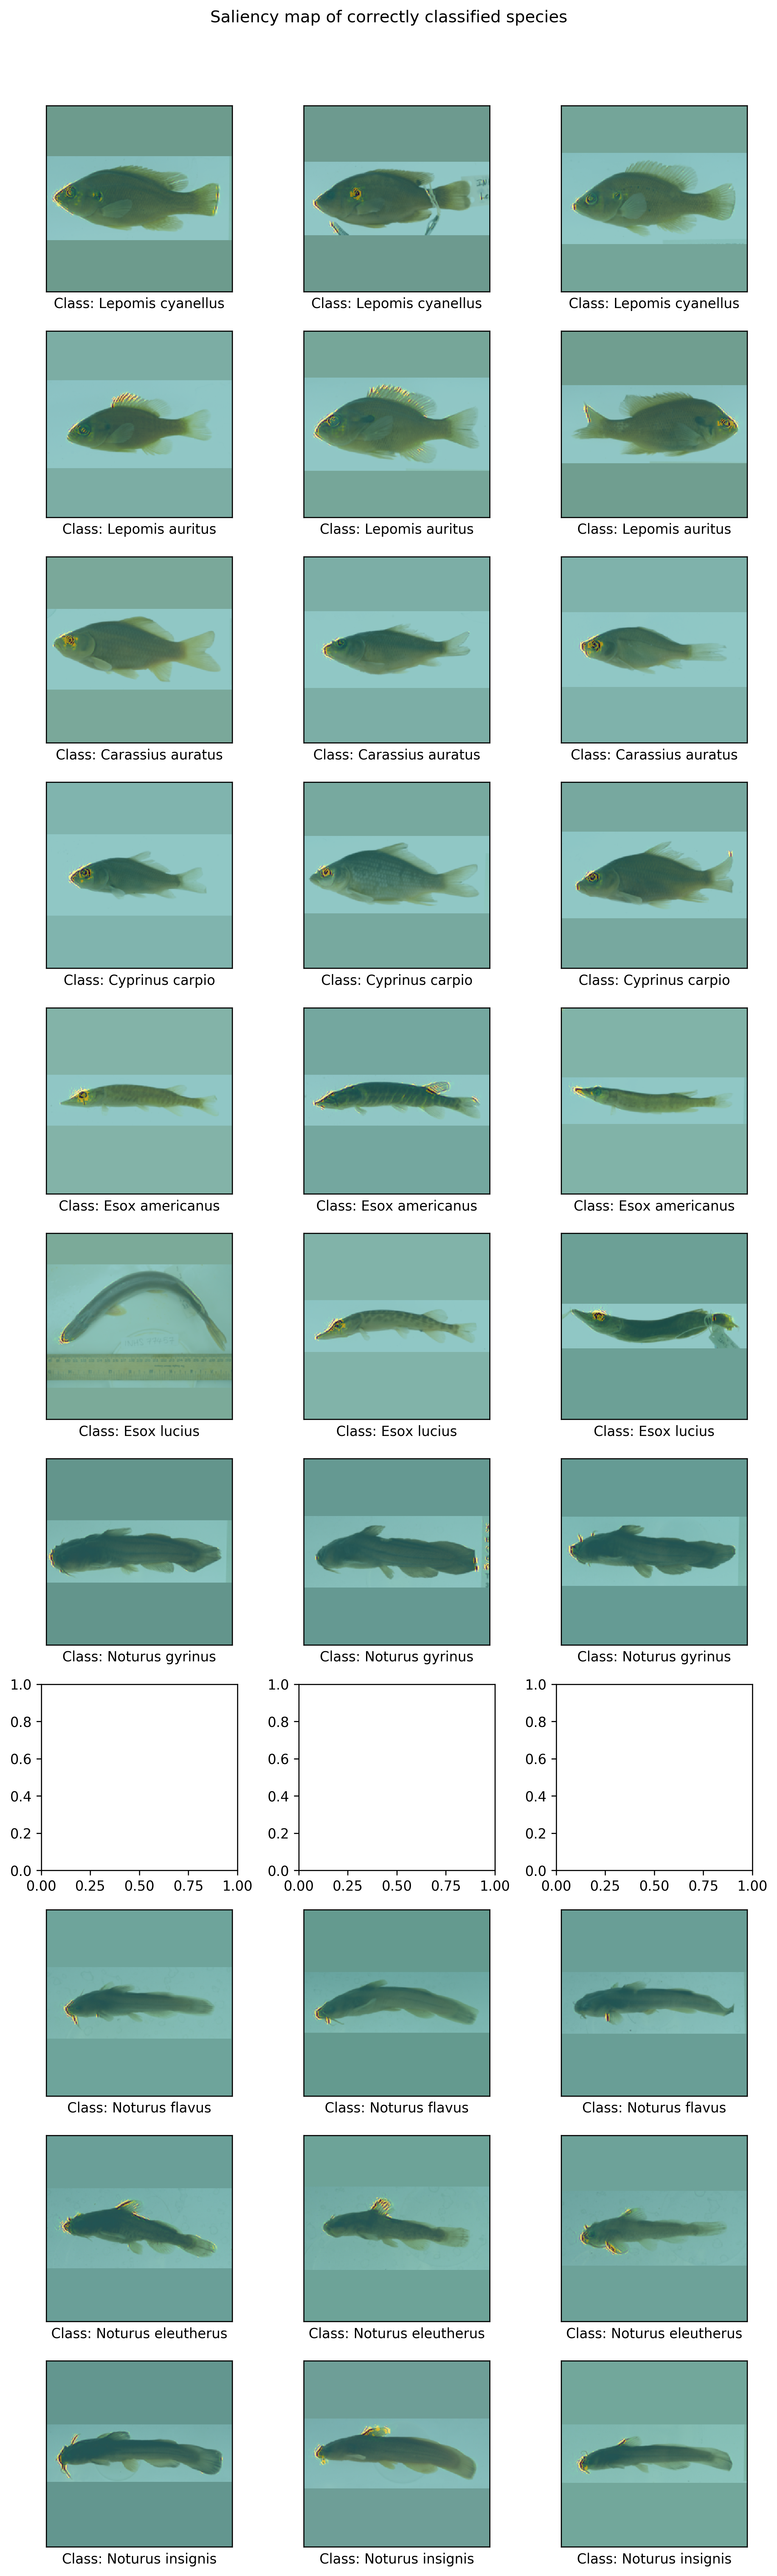

In [31]:
import math

number_per_row = 3
count_species = len(exampleSpecies)*num_per_species
n_rows = math.ceil(count_species/number_per_row)
fig, axes = plt.subplots(n_rows, number_per_row, figsize=(8, 2.5*n_rows), dpi= 300)

for i, ax in enumerate(axes.flat):
    if i < count_species:
        species = int(math.floor(i/num_per_species))
        image = dataLoader.getExample(model, dataset, species, species, experiment_params['useHeirarchy'])
        if image is not None:
        #     if outputs['species']:
        #         target_class = example['species']
        #     elif outputs['genus']:
        #         target_class = example['genus']
        #     print("true class",target_class)
            target_class = species
            unsqueezed = image.unsqueeze(0)

        #     predicted_class = torch.max(wrapped_model(unsqueezed).data, 1)[1].cpu().detach().numpy()[0]
        #     print("predicted class", predicted_class)
            image_tensor = unsqueezed.cpu()
            image_tensor.requires_grad = True
            images = visualize2(backprop, image_tensor, target_class, guided=True, use_gpu=True)
            
            
            ax.set_xlabel("Class: {0}".format(speciesList[species]))
            for image, cmap, alpha in images:
                ax.imshow(image.cpu().detach().numpy(), cmap=cmap, alpha=alpha)
            ax.set_xticks([])
            ax.set_yticks([])
            
fig.suptitle("Saliency map of correctly classified species")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.show()
fig.savefig(os.path.join(experimentName,"SaliencyMap_CorrectExamples.pdf"))

Show incorrectly classified examples

In [15]:
# import math
# # import sys

# # id = 0
# # a = None
# # while True:
# #     print(id)
# #     a = CNN.applyModel(dataset[0]['image'].unsqueeze(0), model)
# #     id = id + 1
    
# exampleSpecies = speciesList
# num_of_species = len(exampleSpecies)
# print(exampleSpecies)

# number_per_row = 4
# count_plots = num_of_species*num_of_species
# n_rows = math.ceil(count_plots/number_per_row)
# fig, axes = plt.subplots(n_rows, number_per_row, figsize=(15, 2.5*n_rows), dpi= 300)

# n_channels = experiment_params["n_channels"]

# species_index_x = -1
# species_index_y = -1
# indx = 0
# for i, ax in enumerate(axes.flat):
#     if indx < count_plots:
#         while True:
#             species_index_x = (species_index_x + 1) % num_of_species
#             if species_index_x == 0:
#                 species_index_y = (species_index_y + 1) % num_of_species
#             if species_index_y == species_index_x:
#                 species_index_x = species_index_x + 1
#             print(species_index_x, species_index_y)
            
#             confusedSpeciesExample = dataLoader.getExample(model, dataset, species_index_x, species_index_y, experiment_params['useHeirarchy'])
#             confusedAsSpeciesExample = dataLoader.getExample(model, dataset, species_index_y, species_index_y, experiment_params['useHeirarchy'])

#             if confusedSpeciesExample is not None and confusedAsSpeciesExample is not None:            
#                 unsqueezed1 = confusedSpeciesExample.unsqueeze(0)
#                 unsqueezed2 = confusedAsSpeciesExample.unsqueeze(0)

#                 image_tensor1 = unsqueezed1.cpu()
#                 image_tensor2 = unsqueezed2.cpu()
#                 image_tensor1.requires_grad = True
#                 image_tensor2.requires_grad = True

#                 images1 = visualize2(backprop, image_tensor1, species_index_x, guided=True, use_gpu=True)
#                 images2 = visualize2(backprop, image_tensor2, species_index_y, guided=True, use_gpu=True)

#                 image11 = images1[0][0]
#                 image12 = images2[0][0]
#                 image21 = images1[1][0]
#                 image22 = images2[1][0]
#                 image1 = torch.cat((image11, image12), 1).cpu().detach().numpy()
#                 image2 = torch.cat((image21, image22), 1).cpu().detach().numpy()
#                 images = [(image1, images1[0][1], images1[0][2]) , (image2, images2[1][1], images2[1][2])]

#                 ax.set_xlabel("{0} as {1}".format(speciesList[species_index_x], speciesList[species_index_y]))
#                 for image, cmap, alpha in images:
#                     ax.imshow(image, cmap=cmap, alpha=alpha)
#                 ax.set_xticks([])
#                 ax.set_yticks([])
#                 indx = indx + 1
#                 break

# fig.suptitle("Saliency map of confused classified species")
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# fig.show()
# fig.savefig(os.path.join(experimentName,"SaliencyMap_ConfusedExamples.pdf"))